In [1]:

# Imports
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import numpy as np
import random


### balanced_dataset

#### This function serves a crucial purpose in preparing data for machine learning tasks, particularly in scenarios where class imbalances exist within the dataset. Here's why it's important to use the balanced dataset function:

- Preventing Bias in Model Training: Class imbalance occurs when certain classes are significantly more prevalent in the dataset than others. Without balancing the dataset, machine learning models may be biased towards the majority class, leading to poor performance in predicting minority classes. Balancing the dataset helps ensure that the model is trained on a representative sample of each class, reducing bias.

- Improving Model Generalization: Imbalanced datasets can lead to models that perform well on the majority class but poorly on minority classes. Balancing the dataset ensures that the model learns to generalize patterns across all classes, resulting in better overall performance and the ability to make accurate predictions on unseen data.

- Enhancing Model Interpretability: Balanced datasets facilitate better understanding and interpretation of model predictions. When the dataset is balanced, the model learns to distinguish between different classes based on their unique characteristics, leading to more interpretable results and insights into the underlying data distribution.

- Mitigating Data Skewness: Class imbalances can cause skewed decision boundaries in machine learning models, leading to suboptimal decision-making. Balancing the dataset helps mitigate this skewness by ensuring that the model learns from a more evenly distributed set of examples, resulting in better decision boundaries and more accurate predictions.

- Reducing Overfitting: Imbalanced datasets can lead to overfitting, where the model memorizes patterns specific to the majority class rather than learning generalizable patterns. Balancing the dataset reduces the likelihood of overfitting by providing the model with a more balanced representation of all classes, thereby improving its ability to generalize to new data.

- Ensuring Fairness and Equity: In applications such as healthcare or finance, where decisions impact individuals' lives, it's essential to ensure fairness and equity in model predictions. Balancing the dataset helps mitigate biases that may disproportionately affect certain groups, thereby promoting fairness and equity in decision-making processes.

In [2]:
def balanced_dataset(file: str, balanced: bool = True) -> list:
    """
    Load the data from the pickle file and organize it in lists for t-SNE and bar chart

    Args: 
        file: the path to the pickle file
        balanced: if the data should be balanced
    
    Returns:
        embeddings: the embeddings of the images
        labels: the labels of the images
        classes: the classes of the images
    """

    # Load the data from the pickle file
    data = pd.read_pickle(file)

    # Initialize the dictionaries
    class_counts = {}
    class_data = {}

    # Organize the data in lists or arrays for t-SNE
    embeddings = []
    labels = []

    # Iterate over the data and organize it in lists
    for syndrome_id, subjects in data.items():
        for subject_id, images in subjects.items():
            for image_id, embedding in images.items():
                if balanced == False:
                    embeddings.append(embedding)
                    labels.append(syndrome_id)
                if syndrome_id in class_data:
                    class_data[syndrome_id].append([syndrome_id, subject_id, image_id, embedding])
                else:
                    class_data[syndrome_id] = [[syndrome_id, subject_id, image_id, embedding]]

                class_counts[syndrome_id] = class_counts.get(syndrome_id, 0) + 1

    # Convert the count data to lists for the bar chart
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    # If the data should be balanced
    if balanced:
        embeddings.clear()
        labels.clear()

        # Perform random balancing
        min_samples = min(counts)

        for syndrome_id, images_list in class_data.items():
            numbers = len(images_list) - min_samples
            excluded_numbers = random.sample(images_list, numbers)

            final_imgs = [image for image in images_list if image not in excluded_numbers]
            for image in final_imgs:
                embeddings.append(image[3])
                labels.append(syndrome_id)

            class_data[syndrome_id] = final_imgs

    return embeddings, labels, classes

### plot_tsne

#### This function is used primarily for visualizing high-dimensional data in a two-dimensional space. Here's why this visualization technique, specifically t-SNE, is valuable:

- Dimensionality Reduction: When dealing with high-dimensional data, such as image embeddings or feature vectors, it becomes challenging to understand and interpret the data. t-SNE helps by reducing the dimensionality of the data while preserving its structure, making it easier to visualize and analyze.

- Cluster Detection: t-SNE is particularly effective at revealing clusters or groups of similar data points in the lower-dimensional space. This is useful for tasks such as pattern recognition and classification, as it can help identify distinct classes or categories within the data.

- Insight into Data Relationships: By visualizing data in a 2D space, t-SNE allows us to gain insights into the relationships between different data points. Data points that are close together in the t-SNE plot are likely to be similar in the original high-dimensional space, while points that are far apart are likely dissimilar.

- Data Exploration and Interpretation: Visualizing data using t-SNE can aid in exploring and interpreting complex datasets. It can help researchers and analysts identify trends, outliers, and anomalies in the data that may not be apparent from the original high-dimensional representation.

- Communicating Results: Visualizations generated by t-SNE are intuitive and easy to understand, making them valuable for communicating findings to stakeholders or presenting results in research papers and presentations.

In [3]:
def plot_tsne(embeddings, labels, classes):
    """
    Plot the t-SNE of the embeddings

    Args:
        embeddings: the embeddings of the images
        labels: the labels of the images
        classes: the classes of the images

    Returns:
        fig: the figure object containing the plot
    """

    # Perform t-SNE and get the 2D embeddings
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)
    x = embeddings_2d[:, 0]
    y = embeddings_2d[:, 1]

    # Plot the t-SNE
    fig = plt.figure(figsize=(6, 5))
    for syndrome_id in classes:
        plt.scatter(x[labels == syndrome_id], y[labels == syndrome_id], label=syndrome_id)
    plt.legend()
    
    return fig

### knn_classifier

#### This function is used for evaluating the performance of a K-Nearest Neighbors (KNN) classifier on a dataset. Here's why this function and its associated analysis are valuable:

- Model Evaluation: KNN is a simple yet effective classification algorithm, but its performance can vary based on factors like distance metric and dataset characteristics. This function helps assess how well KNN performs on a specific dataset using both cosine and Euclidean distances.

- Understanding Performance Across Metrics: By calculating metrics such as accuracy, F1 score, and ROC AUC for both cosine and Euclidean distances, this function provides a comprehensive understanding of the classifier's performance. It allows us to compare how well KNN performs using different distance metrics.

- Identification of Best Distance Metric: Different datasets may benefit from different distance metrics. For instance, cosine distance is often used for text or high-dimensional data, while Euclidean distance may be more suitable for numerical data. This function helps identify which distance metric works better for the given dataset.

- Robustness Assessment with Cross-Validation: The function employs stratified K-Fold cross-validation, which ensures robust evaluation of the classifier's performance. It helps in detecting overfitting or underfitting issues and provides a more reliable estimate of the classifier's performance.

- Visualization of Performance: By plotting ROC curves for each class, the function visualizes the trade-off between true positive rate and false positive rate. This visualization aids in understanding how well the classifier distinguishes between different classes.

- Insights for Model Selection: The evaluation metrics and ROC curves generated by this function can inform model selection decisions. For example, if one distance metric consistently outperforms the other across multiple metrics and folds, it may be preferable for building the final model.

- Documentation and Reporting: The function generates summary statistics and writes them to a text file, facilitating documentation and reporting of the classifier's performance. This information can be valuable for communicating results to stakeholders or for future reference.

In [4]:
def knn_classifier(embeddings, labels, classes):
    """
    Perform KNN classification using cosine and euclidean distances

    Args:
        embeddings: the embeddings of the images
        labels: the labels of the images
        classes: the classes of the images
    """

    # Initialize the lists for the metrics
    cosine_accuracies = []
    cosine_f1_scores = []
    euclidean_accuracies = []
    euclidean_f1_scores = []
    cosine_roc_aucs = []
    euclidean_roc_aucs = []

    # Initialize the stratified k-fold object:
    kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold = 0

    # Performing 10-fold cross-validation:
    for train_index, test_index in kfolds.split(embeddings, labels):
        X_train_fold, X_test_fold = embeddings[train_index], embeddings[test_index]
        y_train_fold, y_test_fold = labels[train_index], labels[test_index]

        # Calculating cosine distance between train and test:
        cosine_dists_train = np.dot(X_train_fold, X_train_fold.T)
        cosine_dists_test = np.dot(X_test_fold, X_train_fold.T)

        # Calculating euclidean distance between train and test:
        euclidean_dists_train = np.linalg.norm(X_train_fold[:, np.newaxis] - X_train_fold, axis=2)
        euclidean_dists_test = np.linalg.norm(X_test_fold[:, np.newaxis] - X_train_fold, axis=2)

        # Fit KNN models with calculated distances:
        knn_cosine = KNeighborsClassifier()
        knn_euclidean = KNeighborsClassifier()
        knn_cosine.fit(cosine_dists_train, y_train_fold)
        knn_euclidean.fit(euclidean_dists_train, y_train_fold)

        # Predict for test using cosine distance:
        y_pred_cosine = knn_cosine.predict(cosine_dists_test)

        # Metrics for cosine distances:
        cosine_accuracy = accuracy_score(y_test_fold, y_pred_cosine)
        cosine_accuracies.append(cosine_accuracy)
        cosine_f1 = f1_score(y_test_fold, y_pred_cosine, average='macro')
        cosine_f1_scores.append(cosine_f1)

        # Predict using euclidean distance:
        y_pred_euclidean = knn_euclidean.predict(euclidean_dists_test)

        # Metrics for euclidean distances:
        euclidean_accuracy = accuracy_score(y_test_fold, y_pred_euclidean)
        euclidean_accuracies.append(euclidean_accuracy)
        euclidean_f1 = f1_score(y_test_fold, y_pred_euclidean, average='macro')
        euclidean_f1_scores.append(euclidean_f1)

        # Increment Fold:
        fold += 1

        # Get classes probabilities:
        y_score_cosine = knn_cosine.predict_proba(cosine_dists_test)

        fpr_cosine = {}  # false positives rate
        tpr_cosine = {}  # true positives rate
        roc_auc_cosine = {}

        # For each class in our data:
        for i, syndrome_id in enumerate(knn_cosine.classes_):
            fpr_cosine[i], tpr_cosine[i], _ = roc_curve(y_test_fold == syndrome_id, y_score_cosine[:, i])
            roc_auc_cosine[i] = auc(fpr_cosine[i], tpr_cosine[i])

        # Retrieve data for this fold:
        cosine_roc_aucs.append(roc_auc_cosine)

        # Get classes probabilities:
        y_score_euclidean = knn_euclidean.predict_proba(euclidean_dists_test)

        fpr_euclidean = {}  # false positives rate
        tpr_euclidean = {}  # true positives rate
        roc_auc_euclidean = {}

        # For each class in our data:
        for i, syndrome_id in enumerate(knn_euclidean.classes_):
            fpr_euclidean[i], tpr_euclidean[i], _ = roc_curve(y_test_fold == syndrome_id, y_score_euclidean[:, i])
            roc_auc_euclidean[i] = auc(fpr_euclidean[i], tpr_euclidean[i])

        # Retrieve data for this fold:
        euclidean_roc_aucs.append(roc_auc_euclidean)

    # Calculate the average ROC AUC for each class across all folds
    avg_roc_auc_cosine = {i: np.mean([roc_auc[i] for roc_auc in cosine_roc_aucs]) for i in range(len(classes))}
    avg_roc_auc_euclidean = {i: np.mean([roc_auc[i] for roc_auc in euclidean_roc_aucs]) for i in range(len(classes))}

    # Plot the ROC AUC for each class
    for i, syndrome_id in enumerate(classes):

        # Print metrics for current fold:
        print(f'\nSyndrome: {syndrome_id}')
        print(f'Accuracy - Cosine Distance: {cosine_accuracy}')
        print(f'Accuracy - Euclidean Distance: {euclidean_accuracy}')
        print(f'F1 Score - Cosine Distance: {cosine_f1}')
        print(f'F1 Score - Euclidean Distance: {euclidean_f1}')

        fig, axs = plt.subplots(2, figsize=(10, 5))  # Create a new figure for each class

        # Get the number of observations for this class
        n_cosine = len([label for label in labels if label == syndrome_id])

        # Plot ROC AUC for cosine distance
        axs[0].plot([0, 1], [0, 1], 'k--')
        axs[0].plot(fpr_cosine[i], tpr_cosine[i], label=f'{syndrome_id} (n={n_cosine}, area = {avg_roc_auc_cosine[i]:.2f})')
        axs[0].set_xlabel('False positive rate')
        axs[0].set_ylabel('True positive rate')
        axs[0].set_title('ROC curve - Cosine Distance')
        axs[0].legend(loc='best')

        # Get the number of observations for this class
        n_euclidean = len([label for label in labels if label == syndrome_id])

        # Plot ROC AUC for euclidean distance
        axs[1].plot([0, 1], [0, 1], 'k--')
        axs[1].plot(fpr_euclidean[i], tpr_euclidean[i], label=f'{syndrome_id} (n={n_euclidean}, area = {avg_roc_auc_euclidean[i]:.2f})')
        axs[1].set_xlabel('False positive rate')
        axs[1].set_ylabel('True positive rate')
        axs[1].set_title('ROC curve - Euclidean Distance')
        axs[1].legend(loc='best')

        plt.tight_layout()
        plt.show()

    # Calculate the average accuracy, F1 score and ROC AUC for each class across all folds
    avg_accuracy_cosine = np.mean(cosine_accuracies)
    avg_f1_cosine = np.mean(cosine_f1_scores)
    avg_roc_auc_cosine = np.mean([roc_auc for roc_auc in avg_roc_auc_cosine.values()])

    avg_accuracy_euclidean = np.mean(euclidean_accuracies)
    avg_f1_euclidean = np.mean(euclidean_f1_scores)
    avg_roc_auc_euclidean = np.mean([roc_auc for roc_auc in avg_roc_auc_euclidean.values()])

    # Create a table for the cosine distance
    table_cosine = [["Accuracy", avg_accuracy_cosine],
                    ["F1 Score", avg_f1_cosine],
                    ["ROC AUC", avg_roc_auc_cosine]]

    # Create a table for the euclidean distance
    table_euclidean = [["Accuracy", avg_accuracy_euclidean],
                    ["F1 Score", avg_f1_euclidean],
                    ["ROC AUC", avg_roc_auc_euclidean]]

    # Write the tables to a txt file
    with open("comparison.txt", "w") as f:
        f.write("Cosine Distance\n")
        f.write(tabulate(table_cosine, headers=["Metric", "Value"], tablefmt="plain"))
        f.write("\n\nEuclidean Distance\n")
        f.write(tabulate(table_euclidean, headers=["Metric", "Value"], tablefmt="plain"))

    return True

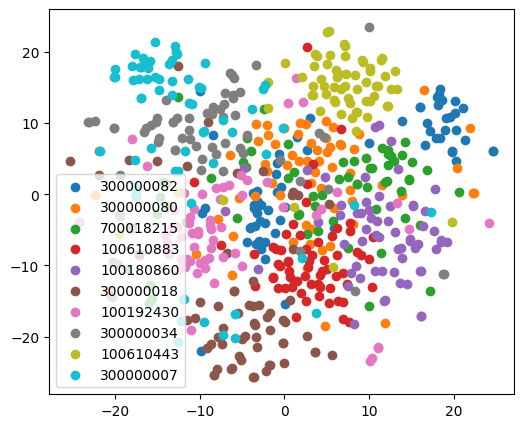


Syndrome: 300000082
Accuracy - Cosine Distance: 0.703125
Accuracy - Euclidean Distance: 0.734375
F1 Score - Cosine Distance: 0.6861339829760882
F1 Score - Euclidean Distance: 0.7130475080475079


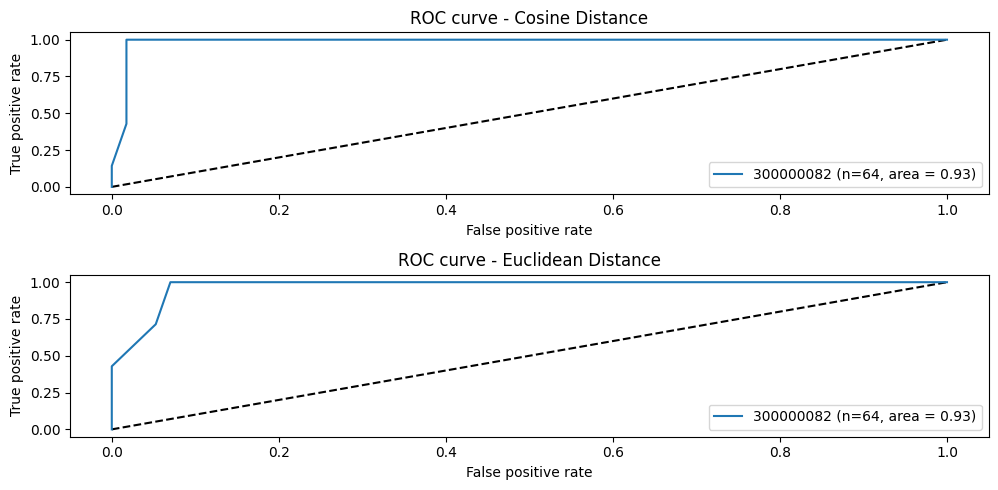


Syndrome: 300000080
Accuracy - Cosine Distance: 0.703125
Accuracy - Euclidean Distance: 0.734375
F1 Score - Cosine Distance: 0.6861339829760882
F1 Score - Euclidean Distance: 0.7130475080475079


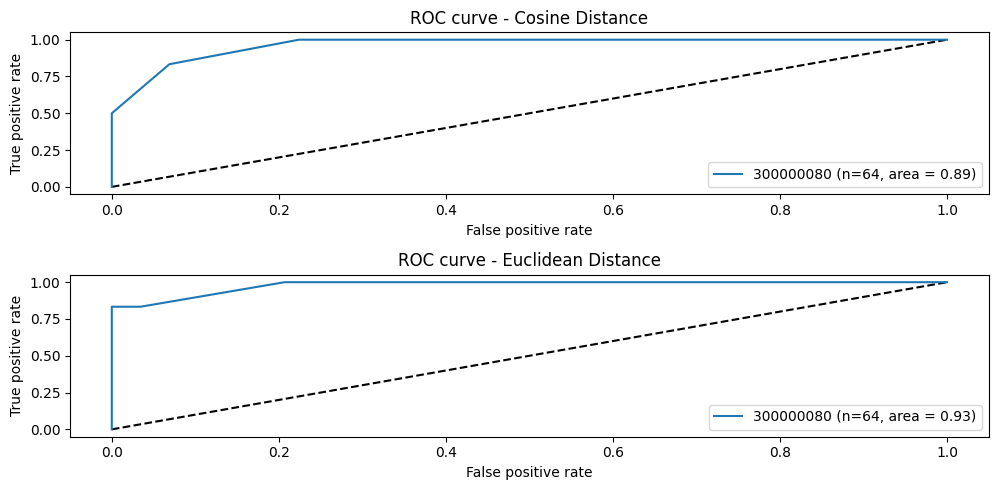


Syndrome: 700018215
Accuracy - Cosine Distance: 0.703125
Accuracy - Euclidean Distance: 0.734375
F1 Score - Cosine Distance: 0.6861339829760882
F1 Score - Euclidean Distance: 0.7130475080475079


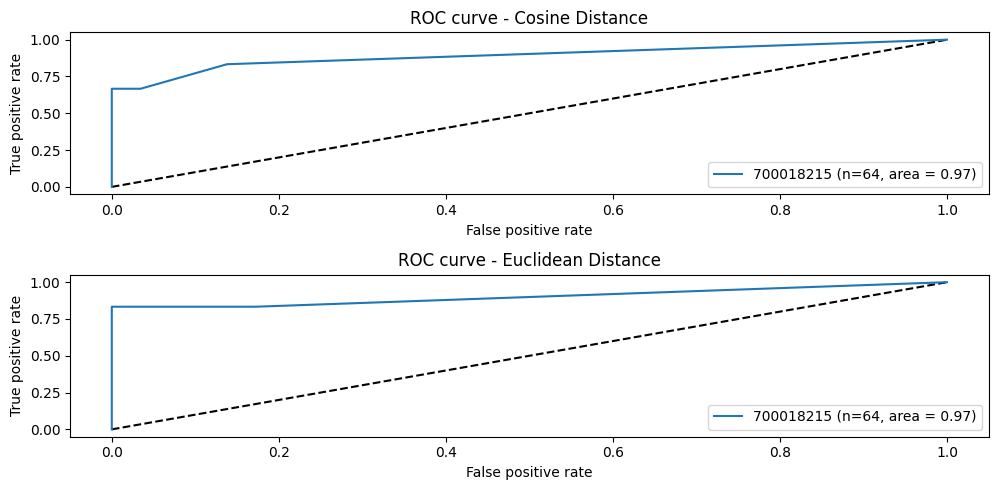


Syndrome: 100610883
Accuracy - Cosine Distance: 0.703125
Accuracy - Euclidean Distance: 0.734375
F1 Score - Cosine Distance: 0.6861339829760882
F1 Score - Euclidean Distance: 0.7130475080475079


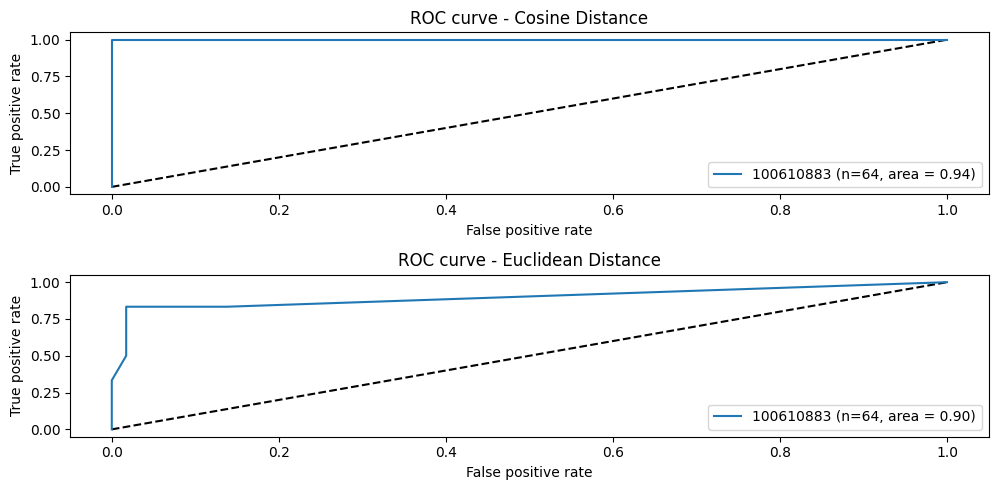


Syndrome: 100180860
Accuracy - Cosine Distance: 0.703125
Accuracy - Euclidean Distance: 0.734375
F1 Score - Cosine Distance: 0.6861339829760882
F1 Score - Euclidean Distance: 0.7130475080475079


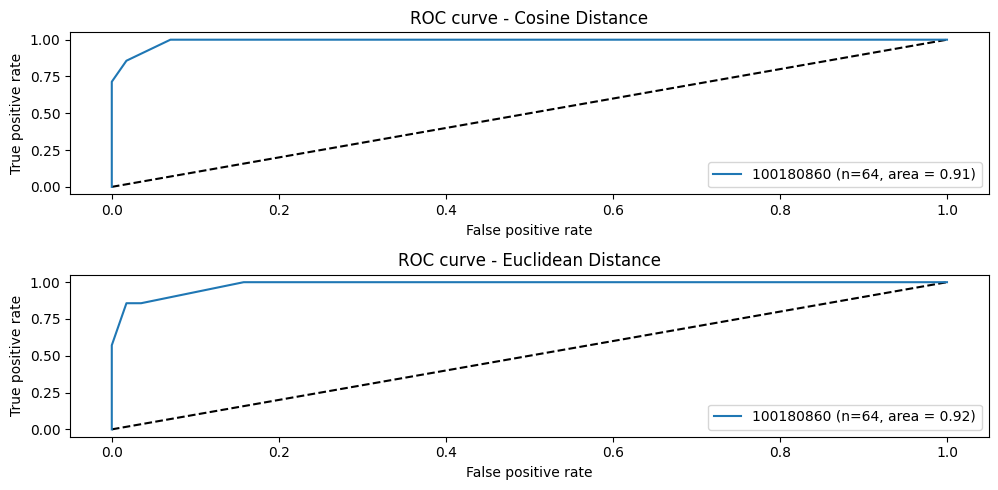


Syndrome: 300000018
Accuracy - Cosine Distance: 0.703125
Accuracy - Euclidean Distance: 0.734375
F1 Score - Cosine Distance: 0.6861339829760882
F1 Score - Euclidean Distance: 0.7130475080475079


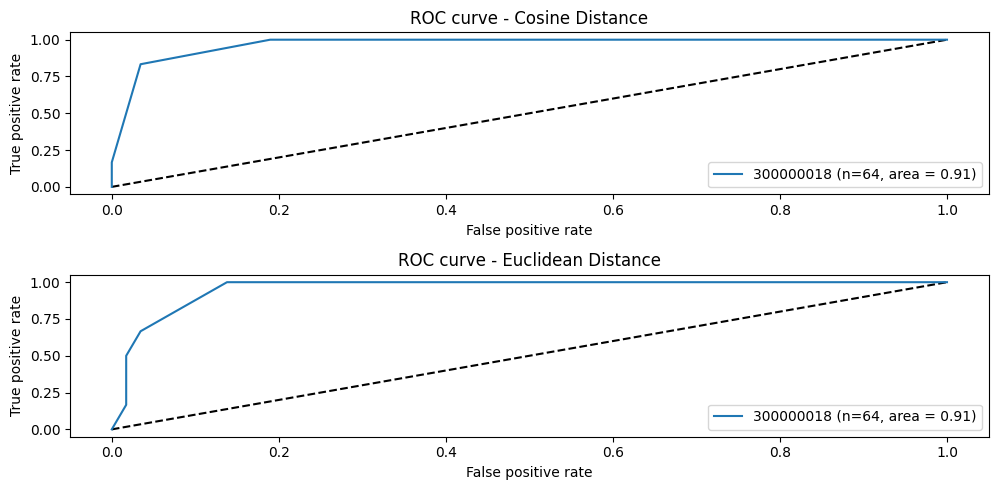


Syndrome: 100192430
Accuracy - Cosine Distance: 0.703125
Accuracy - Euclidean Distance: 0.734375
F1 Score - Cosine Distance: 0.6861339829760882
F1 Score - Euclidean Distance: 0.7130475080475079


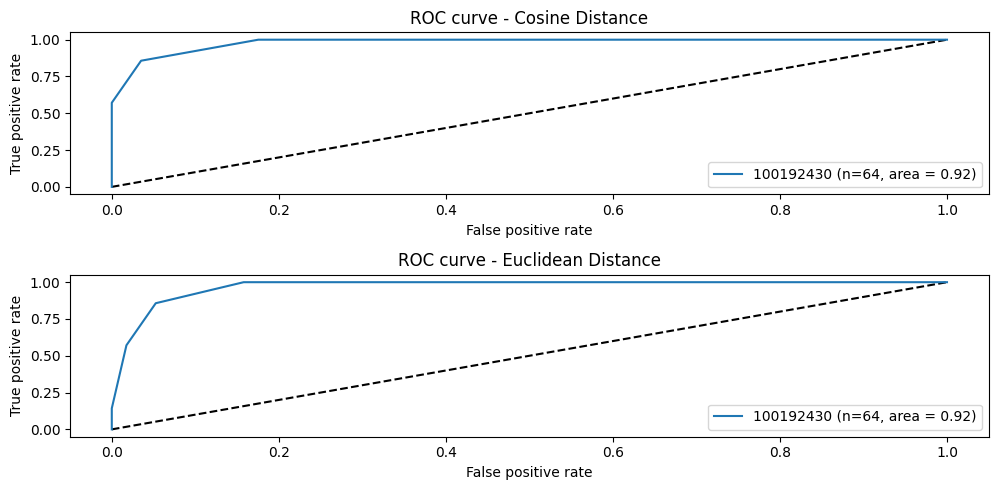


Syndrome: 300000034
Accuracy - Cosine Distance: 0.703125
Accuracy - Euclidean Distance: 0.734375
F1 Score - Cosine Distance: 0.6861339829760882
F1 Score - Euclidean Distance: 0.7130475080475079


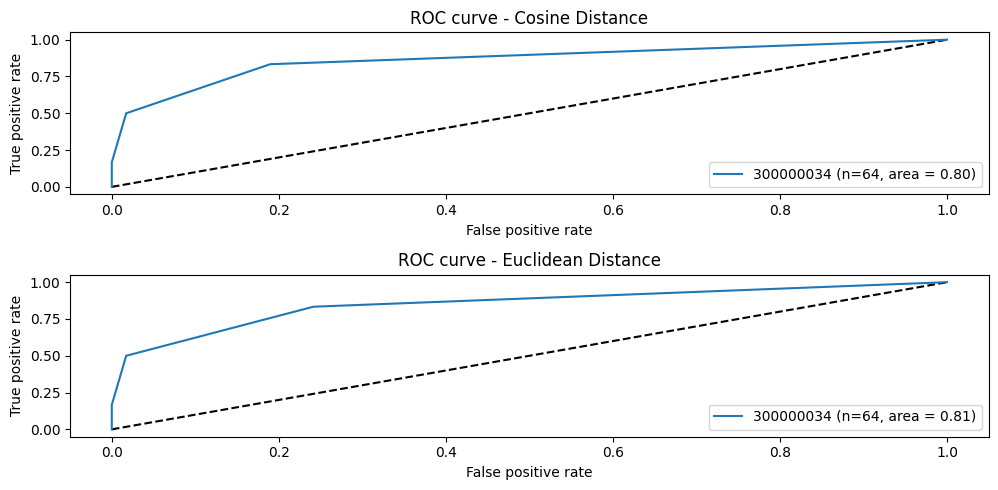


Syndrome: 100610443
Accuracy - Cosine Distance: 0.703125
Accuracy - Euclidean Distance: 0.734375
F1 Score - Cosine Distance: 0.6861339829760882
F1 Score - Euclidean Distance: 0.7130475080475079


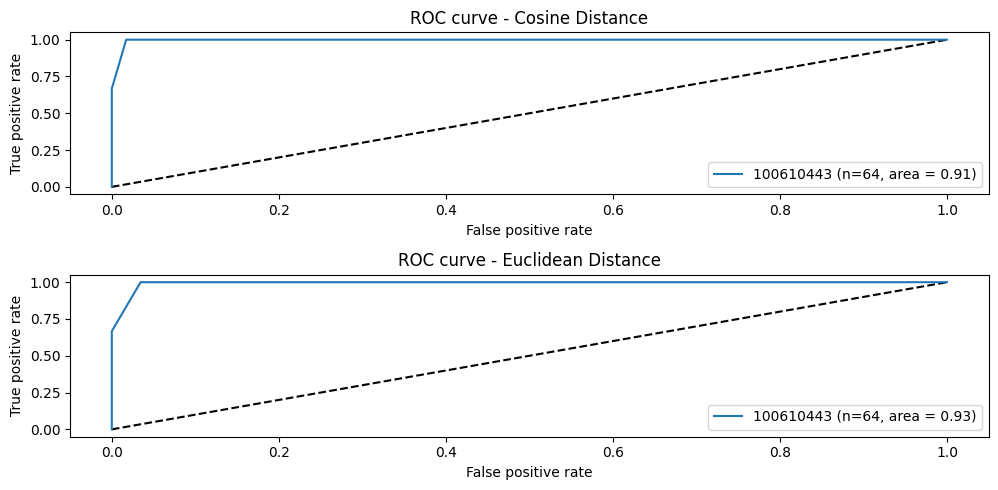


Syndrome: 300000007
Accuracy - Cosine Distance: 0.703125
Accuracy - Euclidean Distance: 0.734375
F1 Score - Cosine Distance: 0.6861339829760882
F1 Score - Euclidean Distance: 0.7130475080475079


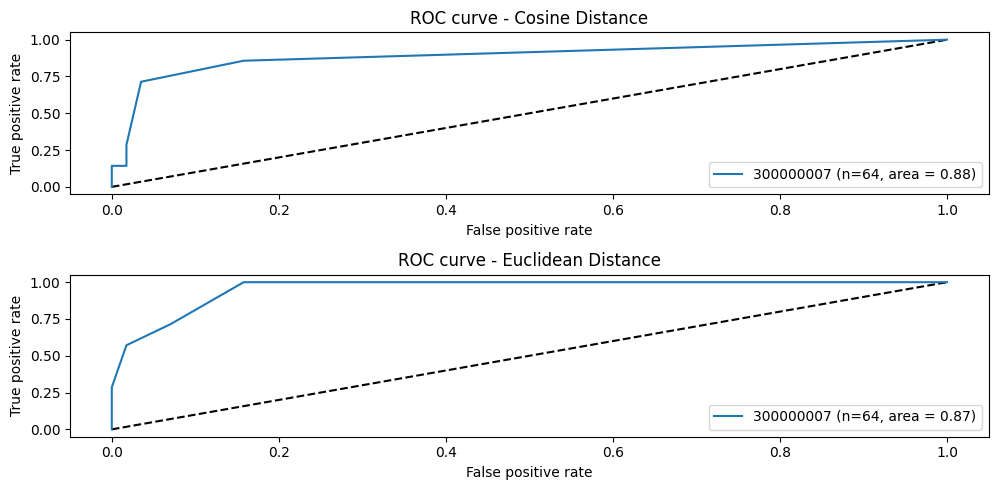

True

In [5]:
# Load the data and perform the t-SNE and KNN classification
embeddings, labels, classes = balanced_dataset('./mini_gm_public_v0.1.p', balanced=True)

# Convert the lists to arrays
embeddings = np.array(embeddings)
labels = np.array(labels)
classes = np.array(classes)

# Perform the t-SNE and KNN classification
plot_tsne(embeddings, labels, classes)

# Perform the KNN classification
knn_classifier(embeddings, labels, classes)